In [511]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from scipy.fftpack import dct, idct

In [589]:
img = Image.open('pexels-andrea-piacquadio-3771079-1024x673.jpg')

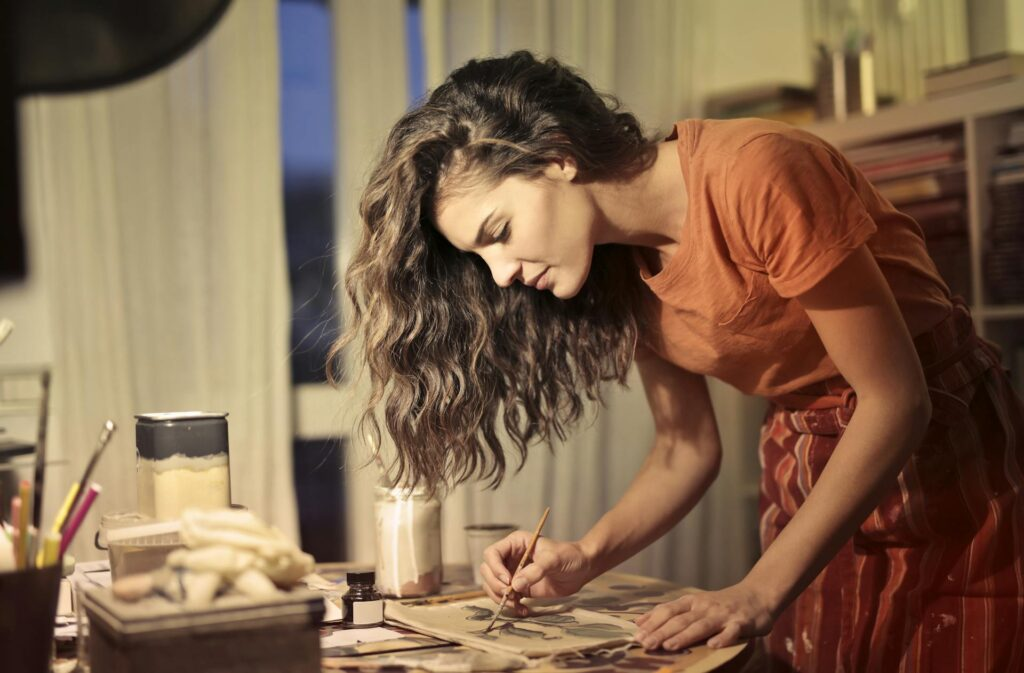

In [590]:
img

In [591]:
img_array = np.array(img)

In [592]:
img_array.shape

(673, 1024, 3)

In [593]:
os.path.getsize('pexels-andrea-piacquadio-3771079-1024x673.jpg')

93990

In [594]:
def central_cropping(img, cropped_h, cropped_w):
    img_height, img_width, img_channel = img.shape
    left = (img_width - cropped_w) // 2
    top = (img_height - cropped_h) // 2
    right = left + cropped_w
    bottom = top + cropped_h
    cropped_img = img[top:bottom, left:right]
    return cropped_img
    

In [595]:
def padding_blocks(img, block=8, mode="symmetric", constant_value=0):
    H, W, C = img.shape
    target = max(H, W)

    # round up to next multiple of `block`
    new_size = ((target + (block - 1)) // block) * block

    pad_h = new_size - H
    pad_w = new_size - W

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    if mode == "constant":
        img_new = np.pad(
            img,
            ((top, bottom), (left, right), (0, 0)),
            mode="constant",
            constant_values=constant_value
        )
    elif mode in ["edge", "reflect", "symmetric"]:
        img_new = np.pad(
            img,
            ((top, bottom), (left, right), (0, 0)),
            mode=mode
        )
    else:
        raise ValueError(f"Unknown mode: {mode}")

    return img_new


In [596]:
cropped_img = padding_blocks(img_array.copy())

In [597]:
cropped_img.shape

(1024, 1024, 3)

In [598]:
original_img = cropped_img.copy()

In [599]:
img_pil = Image.fromarray(cropped_img)

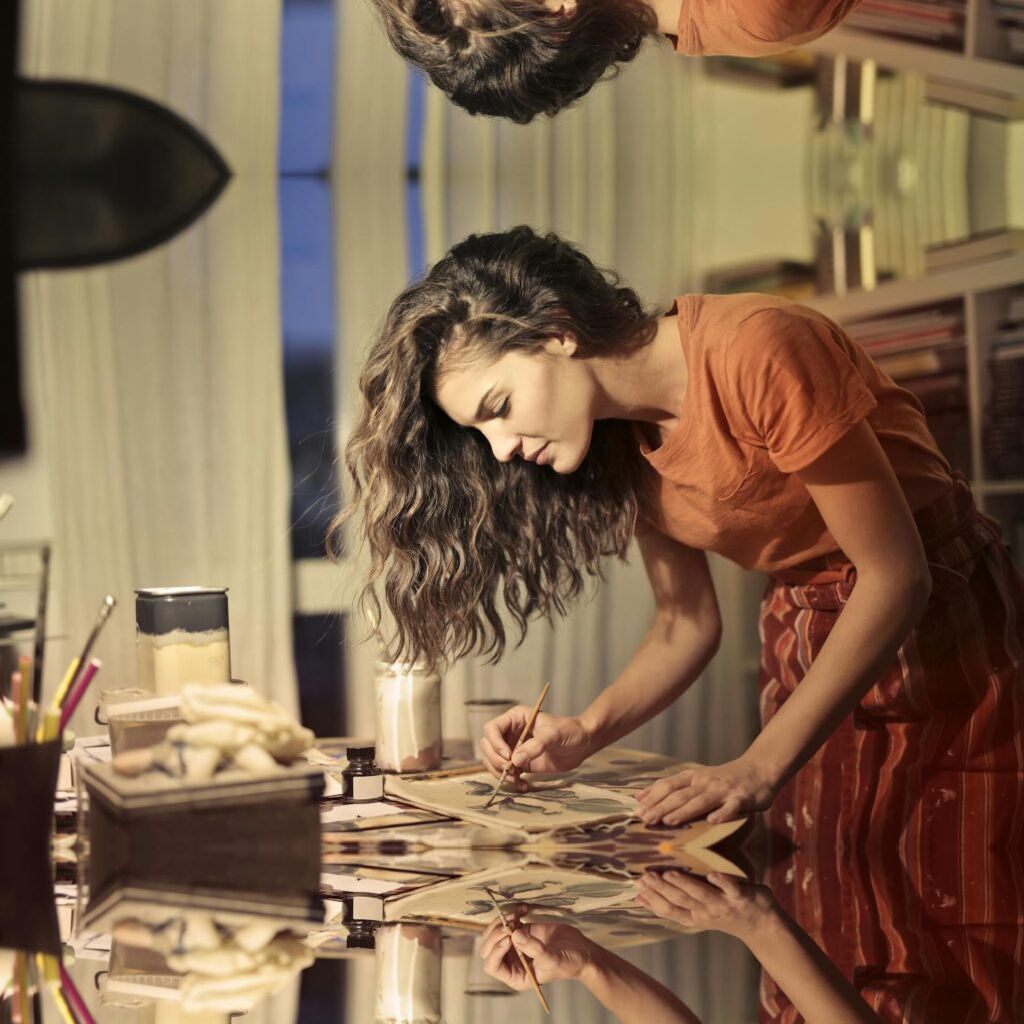

In [600]:
img_pil

In [601]:
from io import BytesIO

buffer = BytesIO()
img_pil.save(buffer, format='PNG')   # or 'JPEG'
size_in_bytes = buffer.getbuffer().nbytes

print(size_in_bytes)

1075479


In [602]:
from io import BytesIO

buffer = BytesIO()
img.save(buffer, format='PNG')   # or 'JPEG'
size_in_bytes = buffer.getbuffer().nbytes

print(size_in_bytes)

721186


In [603]:
cropped_img_R = cropped_img[:, :, 0]
cropped_img_G = cropped_img[:, :, 1]
cropped_img_B = cropped_img[:, :, 2]

In [604]:
cropped_img_Y = 0.299 * cropped_img_R.copy() + 0.587 * cropped_img_G.copy() + 0.114 * cropped_img_B.copy()
cropped_img_Cb =  -0.168736 * cropped_img_R.copy() - 0.331264 * cropped_img_G.copy() + 0.5 * cropped_img_B.copy() + 128
cropped_img_Cr = 0.5 * cropped_img_R.copy() - 0.418688 * cropped_img_G.copy() - 0.081312 * cropped_img_B.copy() + 128

In [605]:
cropped_img_Y.shape

(1024, 1024)

In [606]:
cropped_img_R.shape

(1024, 1024)

In [607]:
cropped_img_Cr

array([[130.069184, 130.069184, 130.069184, ..., 143.207552, 143.207552,
        143.207552],
       [130.069184, 130.069184, 130.069184, ..., 142.382304, 142.382304,
        142.12624 ],
       [130.069184, 130.069184, 130.069184, ..., 140.138368, 140.800992,
        140.800992],
       ...,
       [140.825248, 139.987872, 139.987872, ..., 143.150496, 143.150496,
        143.150496],
       [140.825248, 140.90656 , 140.150496, ..., 143.150496, 143.150496,
        143.150496],
       [142.325248, 140.90656 , 140.150496, ..., 143.150496, 143.150496,
        143.150496]], shape=(1024, 1024))

In [608]:
h, w = cropped_img_Cr.shape
blocked_imgY = np.zeros((h*w // 64, 8, 8))

index = 0
for i in range(0, h, 8):
    for j in range(0, w, 8):
        blocked_imgY[index] = cropped_img_Y[i:i+8, j:j+8]
        index += 1

In [609]:
blocked_imgY

array([[[11.099, 11.099, 11.099, ..., 12.099, 12.327, 12.327],
        [11.099, 11.099, 11.099, ..., 12.099, 12.327, 12.327],
        [11.099, 11.099, 11.099, ..., 12.099, 12.327, 12.327],
        ...,
        [11.099, 11.099, 11.099, ..., 12.099, 12.327, 12.327],
        [11.099, 11.099, 11.099, ..., 12.099, 12.327, 12.327],
        [12.099, 12.099, 12.099, ..., 12.099, 12.327, 12.327]],

       [[12.327, 12.327, 11.854, ..., 13.854, 14.854, 16.327],
        [12.327, 12.327, 11.854, ..., 13.854, 14.854, 16.327],
        [12.327, 12.327, 11.854, ..., 13.854, 14.854, 16.327],
        ...,
        [12.327, 12.327, 11.854, ..., 13.854, 14.854, 16.327],
        [12.327, 12.327, 11.854, ..., 13.854, 14.854, 16.327],
        [12.327, 12.327, 11.854, ..., 12.854, 15.854, 19.327]],

       [[22.05 , 29.409, 40.181, ..., 69.91 , 81.981, 91.226],
        [22.05 , 30.409, 41.181, ..., 70.91 , 82.981, 91.226],
        [23.05 , 30.409, 41.181, ..., 70.91 , 82.981, 92.226],
        ...,
        [24.

In [610]:
blocked_imgY.shape

(16384, 8, 8)

In [611]:
h, w = cropped_img_Cb.shape
blocked_imgCb = np.zeros((h*w // 64, 8, 8))

index = 0
for i in range(0, h, 8):
    for j in range(0, w, 8):
        blocked_imgCb[index] = cropped_img_Cb[i:i+8, j:j+8]
        index += 1

In [612]:
h, w = cropped_img_Cb.shape
blocked_imgCr = np.zeros((h*w // 64, 8, 8))

index = 0
for i in range(0, h, 8):
    for j in range(0, w, 8):
        blocked_imgCr[index] = cropped_img_Cr[i:i+8, j:j+8]
        index += 1

In [613]:
def complement_pixels(img):
        return img.astype(np.float32) - 128.0

In [614]:
blocked_imgYcomp = complement_pixels(blocked_imgY.copy()) 
blocked_imgCbcomp = complement_pixels(blocked_imgCb.copy()) 
blocked_imgCrcomp = complement_pixels(blocked_imgCr.copy()) 

In [615]:
blocked_imgCb

array([[[123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792],
        [123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792],
        [123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792],
        ...,
        [123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792],
        [123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792],
        [123.993792, 123.993792, 123.993792, ..., 123.993792,
         124.993792, 124.993792]],

       [[124.993792, 124.993792, 125.825056, ..., 125.825056,
         125.825056, 124.993792],
        [124.993792, 124.993792, 125.825056, ..., 125.825056,
         125.825056, 124.993792],
        [124.993792, 124.993792, 125.825056, ..., 125.825056,
         125.825056, 124.993792],
        ...,
        [124.993792, 124.993792, 125.825056, ..., 125.825056,
         125.825056, 124.993792],
        [124

In [616]:
blocked_imgYcomp[0]

array([[-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-116.901   , -116.901   , -116.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004],
       [-115.901   , -115.901   , -115.901   , -115.901   , -115.901   ,
        -115.901   , -115.673004, -115.673004]], dtype=float32)

In [617]:
blocked_imgYcomp.shape

(16384, 8, 8)

In [618]:
def forward_dct_2d(block):
    block = np.array(block, dtype=float)      # convert list → array
    dct_block = dct(dct(block.T, axis=0, norm='ortho').T, axis=0, norm='ortho')
    return dct_block


In [619]:
def calculate_dct_img(img):
    h, w, c = img.shape
    res = np.zeros_like(img, dtype=float)
    for i in range(h):
        res[i] = forward_dct_2d(img[i])
    return res

In [620]:
blocked_imgYdct = calculate_dct_img(blocked_imgYcomp.copy())
blocked_imgCbdct = calculate_dct_img(blocked_imgCbcomp.copy())
blocked_imgCrdct = calculate_dct_img(blocked_imgCrcomp.copy())

In [621]:
blocked_imgYdct

array([[[-9.29377014e+02, -3.51437069e+00, -7.21959392e-01, ...,
          4.21869545e-01, -6.48047804e-01, -4.66588246e-01],
        [-5.20139942e-01, -5.80582007e-01, -2.26531862e-01, ...,
          5.64257358e-02, -9.38325694e-02, -1.15484942e-01],
        [ 4.89961112e-01,  5.46896293e-01,  2.13388348e-01, ...,
         -5.31518809e-02,  8.83883476e-02,  1.08784436e-01],
        ...,
        [-2.94635609e-01, -3.28873289e-01, -1.28319992e-01, ...,
          3.19626118e-02, -5.31518809e-02, -6.54169645e-02],
        [ 2.02948538e-01,  2.26531862e-01,  8.83883476e-02, ...,
         -2.20162299e-02,  3.66116524e-02,  4.50599889e-02],
        [-1.03462267e-01, -1.15484942e-01, -4.50599889e-02, ...,
          1.12237767e-02, -1.86644585e-02, -2.29713831e-02]],

       [[-9.17748993e+02, -1.09013209e+01,  7.06807515e+00, ...,
         -1.30517709e+00,  2.90250704e-01, -1.14497315e-01],
        [ 0.00000000e+00,  7.41268908e-01, -1.54685631e+00, ...,
         -8.35223297e-02, -1.09931693e

In [622]:
def quantization(img, quantType):
    h, w, c = img.shape
    if quantType == 'Y':
        quant_matrix = [
                            # [ 8,  6,  6,  8, 12, 20, 26, 31],
                            # [ 6,  6,  7, 10, 13, 29, 30, 28],
                            # [ 7,  7,  8, 12, 20, 29, 35, 28],
                            # [ 7,  9, 11, 15, 26, 44, 40, 31],
                            # [ 9, 11, 19, 28, 34, 55, 52, 39],
                            # [12, 18, 28, 32, 41, 52, 57, 46],
                            # [25, 32, 39, 44, 52, 61, 60, 50],
                            # [36, 46, 48, 49, 56, 50, 52, 50]
                            [16,11,10,16,24,40,51,61],
                            [12,12,14,19,26,58,60,55],
                            [14,13,16,24,40,57,69,56],
                            [14,17,22,29,51,87,80,62],
                            [18,22,37,56,68,109,103,77],
                            [24,35,55,64,81,104,113,92],
                            [49,64,78,87,103,121,120,101],
                            [72,92,95,98,112,100,103,99]
                        ]
    else:
        quant_matrix = [
                            # [ 9,  9, 12, 24, 50, 50, 50, 50],
                            # [ 9, 11, 13, 33, 50, 50, 50, 50],
                            # [12, 13, 28, 50, 50, 50, 50, 50],
                            # [24, 33, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50]
                            [17,18,24,47,99,99,99,99],
                            [18,21,26,66,99,99,99,99],
                            [24,26,56,99,99,99,99,99],
                            [47,66,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99]
                      ]
    for i in range(h):
        img[i] = img[i] / quant_matrix
    return img

In [623]:
blocked_imgYquant = quantization(blocked_imgYdct.copy(), 'Y')
blocked_imgCbquant = quantization(blocked_imgCbdct.copy(), 'Cb')
blocked_imgCrquant = quantization(blocked_imgCrdct.copy(), 'Cr')

In [624]:
blocked_imgYquant.shape

(16384, 8, 8)

In [625]:
non_zero_count = np.count_nonzero(blocked_imgCbquant)
print(non_zero_count)

821594


In [626]:
import numpy as np
import heapq
from collections import Counter

# Standard JPEG zigzag order for 8x8 blocks
ZIGZAG_INDICES = [
    (0,0),
    (0,1),(1,0),
    (2,0),(1,1),(0,2),
    (0,3),(1,2),(2,1),(3,0),
    (4,0),(3,1),(2,2),(1,3),(0,4),
    (0,5),(1,4),(2,3),(3,2),(4,1),(5,0),
    (6,0),(5,1),(4,2),(3,3),(2,4),(1,5),(0,6),
    (0,7),(1,6),(2,5),(3,4),(4,3),(5,2),(6,1),(7,0),
    (7,1),(6,2),(5,3),(4,4),(3,5),(2,6),(1,7),
    (2,7),(3,6),(4,5),(5,4),(6,3),(7,2),
    (7,3),(6,4),(5,5),(4,6),(3,7),
    (4,7),(5,6),(6,5),(7,4),
    (7,5),(6,6),(5,7),
    (6,7),(7,6),
    (7,7)
]

def zigzag(block: np.ndarray) -> np.ndarray:
    block = np.asarray(block)
    assert block.shape == (8, 8)
    return np.array([block[i, j] for (i, j) in ZIGZAG_INDICES], dtype=block.dtype)

def inverse_zigzag(vec: np.ndarray) -> np.ndarray:
    vec = np.asarray(vec)
    assert vec.size == 64
    block = np.zeros((8, 8), dtype=vec.dtype)
    for idx, (i, j) in enumerate(ZIGZAG_INDICES):
        block[i, j] = vec[idx]
    return block


In [627]:
def rle_encode_block(coeffs: np.ndarray):
    """
    coeffs: (64,) quantized coefficients in zigzag order.
    Returns list of symbols:
      ('DC', dc_val)
      ('AC', run, val)
      ('ZRL', 15, 0)
      ('EOB', 0, 0)  # always at end
    """
    coeffs = np.asarray(coeffs).astype(int).tolist()
    assert len(coeffs) == 64

    symbols = []

    # DC
    symbols.append(('DC', coeffs[0]))

    zero_run = 0
    for v in coeffs[1:]:
        v = int(v)
        if v == 0:
            zero_run += 1
        else:
            # output ZRL for each 16 zeros
            while zero_run >= 16:
                symbols.append(('ZRL', 15, 0))
                zero_run -= 16
            symbols.append(('AC', zero_run, v))
            zero_run = 0

    # Always terminate block explicitly
    symbols.append(('EOB', 0, 0))

    return symbols

def rle_decode_block(symbols):
    """
    symbols: list of ('DC', val) / ('AC', run, val) / ('ZRL', 15, 0) / ('EOB', 0, 0)
    Returns: (64,) coefficients.
    """
    coeffs = []

    it = iter(symbols)
    first = next(it)
    assert first[0] == 'DC'
    coeffs.append(int(first[1]))

    for sym in it:
        kind = sym[0]
        if kind == 'AC':
            run, val = sym[1], sym[2]
            coeffs.extend([0] * int(run))
            coeffs.append(int(val))
        elif kind == 'ZRL':
            run = sym[1]  # usually 15
            coeffs.extend([0] * int(run))
        elif kind == 'EOB':
            break
        else:
            raise ValueError(f"Unknown RLE symbol kind: {sym}")

    # pad to 64
    if len(coeffs) < 64:
        coeffs.extend([0] * (64 - len(coeffs)))

    return np.array(coeffs, dtype=np.int32)


In [628]:
class HuffmanNode:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq


In [629]:
def build_huffman_code(symbols):
    """
    symbols: list of hashable items (our RLE tuples)
    returns: {symbol -> bitstring}
    """
    freq = Counter(symbols)
    heap = [HuffmanNode(f, symbol=s) for s, f in freq.items()]
    if not heap:
        return {}
    heapq.heapify(heap)

    if len(heap) == 1:
        # only one symbol
        return {heap[0].symbol: '0'}

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = HuffmanNode(n1.freq + n2.freq, left=n1, right=n2)
        heapq.heappush(heap, merged)

    root = heap[0]
    codebook = {}

    def dfs(node, prefix):
        if node.symbol is not None:
            codebook[node.symbol] = prefix or '0'
        else:
            dfs(node.left, prefix + '0')
            dfs(node.right, prefix + '1')

    dfs(root, '')
    return codebook


In [630]:
def huffman_encode(symbols, codebook):
    """
    symbols: list of RLE symbols
    returns: bitstring '010101...'
    """
    return ''.join(codebook[s] for s in symbols)

def _build_decoding_trie(codebook):
    root = {}
    for sym, bits in codebook.items():
        node = root
        for b in bits:
            node = node.setdefault(b, {})
        node['sym'] = sym
    return root

def huffman_decode(bitstream, codebook):
    """
    bitstream: '010101...'
    returns: list of RLE symbols
    """
    root = _build_decoding_trie(codebook)
    out = []
    node = root
    for b in bitstream:
        node = node[b]
        if 'sym' in node:
            out.append(node['sym'])
            node = root
    return out


In [631]:
def encode_channel(blocks_quant: np.ndarray):
    """
    blocks_quant: (num_blocks, 8, 8) quantized coefficients
    returns: bitstream (str), codebook (dict), num_blocks (int)
    """
    all_symbols = []
    for block in blocks_quant:
        zz = zigzag(block)
        syms = rle_encode_block(zz)
        all_symbols.extend(syms)

    codebook = build_huffman_code(all_symbols)
    bitstream = huffman_encode(all_symbols, codebook)
    return bitstream, codebook, blocks_quant.shape[0]

def decode_channel(bitstream: str, codebook, num_blocks: int):
    """
    bitstream, codebook from encode_channel
    returns: (num_blocks, 8, 8) quantized coefficients (same as input to encode_channel)
    """
    syms = huffman_decode(bitstream, codebook)

    blocks = []
    current = []
    blocks_done = 0

    for sym in syms:
        current.append(sym)
        if sym[0] == 'EOB':
            coeffs = rle_decode_block(current)
            block = inverse_zigzag(coeffs)
            blocks.append(block)
            current = []
            blocks_done += 1
            if blocks_done == num_blocks:
                break

    return np.stack(blocks, axis=0)


In [632]:
y_bits, y_codebook, y_nblocks = encode_channel(blocked_imgYquant.copy())
blocked_imgYquant_after = decode_channel(y_bits, y_codebook, y_nblocks)

In [633]:
cb_bits, cb_codebook, cb_nblocks = encode_channel(blocked_imgCbquant.copy())
blocked_imgCbquant_after = decode_channel(cb_bits, cb_codebook, cb_nblocks)

In [634]:
cr_bits, cr_codebook, cr_nblocks = encode_channel(blocked_imgCrquant.copy())
blocked_imgCrquant_after = decode_channel(cr_bits, cr_codebook, cr_nblocks)

In [635]:
blocked_imgCrquant_after.shape

(16384, 8, 8)

In [636]:
def re_quantization(img, quantType):
    h, w, c = img.shape
    if quantType == 'Y':
        quant_matrix = [
                            # [ 8,  6,  6,  8, 12, 20, 26, 31],
                            # [ 6,  6,  7, 10, 13, 29, 30, 28],
                            # [ 7,  7,  8, 12, 20, 29, 35, 28],
                            # [ 7,  9, 11, 15, 26, 44, 40, 31],
                            # [ 9, 11, 19, 28, 34, 55, 52, 39],
                            # [12, 18, 28, 32, 41, 52, 57, 46],
                            # [25, 32, 39, 44, 52, 61, 60, 50],
                            # [36, 46, 48, 49, 56, 50, 52, 50]
                            [16,11,10,16,24,40,51,61],
                            [12,12,14,19,26,58,60,55],
                            [14,13,16,24,40,57,69,56],
                            [14,17,22,29,51,87,80,62],
                            [18,22,37,56,68,109,103,77],
                            [24,35,55,64,81,104,113,92],
                            [49,64,78,87,103,121,120,101],
                            [72,92,95,98,112,100,103,99]
                        ]
    else:
        quant_matrix = [
                            # [ 9,  9, 12, 24, 50, 50, 50, 50],
                            # [ 9, 11, 13, 33, 50, 50, 50, 50],
                            # [12, 13, 28, 50, 50, 50, 50, 50],
                            # [24, 33, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50],
                            # [50, 50, 50, 50, 50, 50, 50, 50]
                            [17,18,24,47,99,99,99,99],
                            [18,21,26,66,99,99,99,99],
                            [24,26,56,99,99,99,99,99],
                            [47,66,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99],
                            [99,99,99,99,99,99,99,99]
                      ]
    for i in range(h):
        img[i] = img[i].astype(np.float32) * quant_matrix
    return img

In [637]:
blocked_imgYquant_after.shape

(16384, 8, 8)

In [638]:
blocked_imgYde_quant = re_quantization(blocked_imgYquant_after.copy(), 'Y')
blocked_imgCbde_quant = re_quantization(blocked_imgCbquant_after.copy(), 'Cb')
blocked_imgCrde_quant = re_quantization(blocked_imgCrquant_after.copy(), 'Cr')

In [639]:
blocked_imgYde_quant.shape

(16384, 8, 8)

In [640]:
def inverse_dct_2d(dct_block):
    dct_block = np.array(dct_block, dtype=float)
    block = idct(idct(dct_block.T, axis=0, norm='ortho').T,
                 axis=0, norm='ortho')
    return block

In [641]:
def calculate_idct_img(dct_img):
    h, w, c = dct_img.shape
    res = np.zeros_like(dct_img, dtype=float)

    for i in range(h):
        res[i] = inverse_dct_2d(dct_img[i])

    return res

In [642]:
blocked_imgYidct = calculate_idct_img(blocked_imgYde_quant.copy())
blocked_imgCbidct = calculate_idct_img(blocked_imgCbde_quant.copy())
blocked_imgCridct = calculate_idct_img(blocked_imgCrde_quant.copy())

In [643]:
blocked_imgCridct.shape

(16384, 8, 8)

In [644]:
blocked_imgCridct

array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 4.25 ,  4.25 ,  4.25 , ...,  4.25 ,  4.25 ,  4.25 ],
        [ 4.25 ,  4.25 ,  4.25 , ...,  4.25 ,  4.25 ,  4.25 ],
        [ 4.25 ,  4.25 ,  4.25 , ...,  4.25 ,  4.25 ,  4.25 ],
        ...,
        [ 4.

In [645]:
def scale_ahead(img):
    return img.astype(np.float32) + 128.0

In [646]:
blocked_imgYscale_ahead = scale_ahead(blocked_imgYidct.copy())
blocked_imgCbscale_ahead = scale_ahead(blocked_imgCbidct.copy())
blocked_imgCrscale_ahead = scale_ahead(blocked_imgCridct.copy())

In [647]:
blocked_imgYidct[0][0][0] - blocked_imgYscale_ahead[0][0][0]

np.float64(-128.0)

In [648]:
blocked_imgYscale_ahead.shape[0]

16384

In [649]:
def blocks_to_image(blocks, img_h, img_w, block_size=8):
    img = np.zeros((img_h, img_w), dtype=np.float32)
    idx = 0
    blocks_per_row = img_w // block_size

    for i in range(0, img_h, block_size):
        for j in range(0, img_w, block_size):
            img[i:i+block_size, j:j+block_size] = blocks[idx]
            idx += 1

    return img


In [650]:
import math
h, w = int(math.sqrt(blocked_imgYscale_ahead.shape[0] * blocked_imgYscale_ahead.shape[1] * blocked_imgYscale_ahead.shape[2])), int(math.sqrt(blocked_imgYscale_ahead.shape[0] * blocked_imgYscale_ahead.shape[1] * blocked_imgYscale_ahead.shape[2]))
unblocked_imgY = blocks_to_image(blocked_imgYscale_ahead.copy(), h, w)
unblocked_imgCb = blocks_to_image(blocked_imgCbscale_ahead.copy(), h, w)
unblocked_imgCr = blocks_to_image(blocked_imgCrscale_ahead.copy(), h, w)

In [651]:
unblocked_imgY.shape

(1024, 1024)

In [652]:
Y  = unblocked_imgY.copy()
Cb = unblocked_imgCb.copy()
Cr = unblocked_imgCr.copy()

unblocked_imgR = Y + 1.402 * (Cr - 128)
unblocked_imgG = Y - 0.344136 * (Cb - 128) - 0.714136 * (Cr - 128)
unblocked_imgB = Y + 1.772 * (Cb - 128)

In [653]:
rgb_img = np.stack([
    np.clip(unblocked_imgR, 0, 255),
    np.clip(unblocked_imgG, 0, 255),
    np.clip(unblocked_imgB, 0, 255)
], axis=-1).astype(np.uint8)

In [654]:
jpeg_compressed = Image.fromarray(rgb_img)

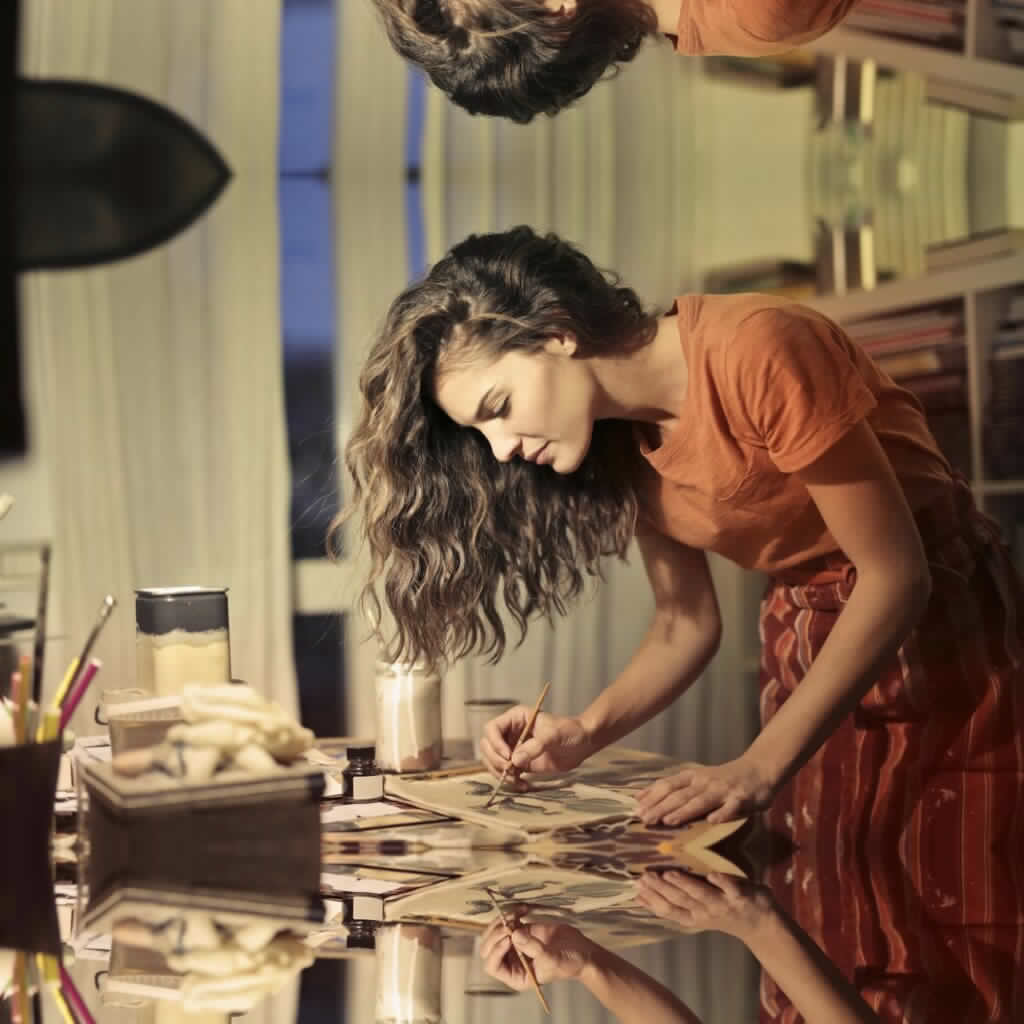

In [655]:
jpeg_compressed

In [656]:
def unpadding_blocks_exact(padded_img, orig_shape, block=8):
    H, W, C = orig_shape.shape
    H_pad, W_pad, _ = padded_img.shape

    pad_h = H_pad - H
    pad_w = W_pad - W

    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    return padded_img[
        top : H_pad - bottom,
        left : W_pad - right,
        :
    ]


In [657]:
img_unpadding_blocks = unpadding_blocks_exact(rgb_img, img_array)

In [658]:
img_unpadding_blocks.shape

(673, 1024, 3)

In [659]:
jpeg_compressed_org_size = Image.fromarray(img_unpadding_blocks)

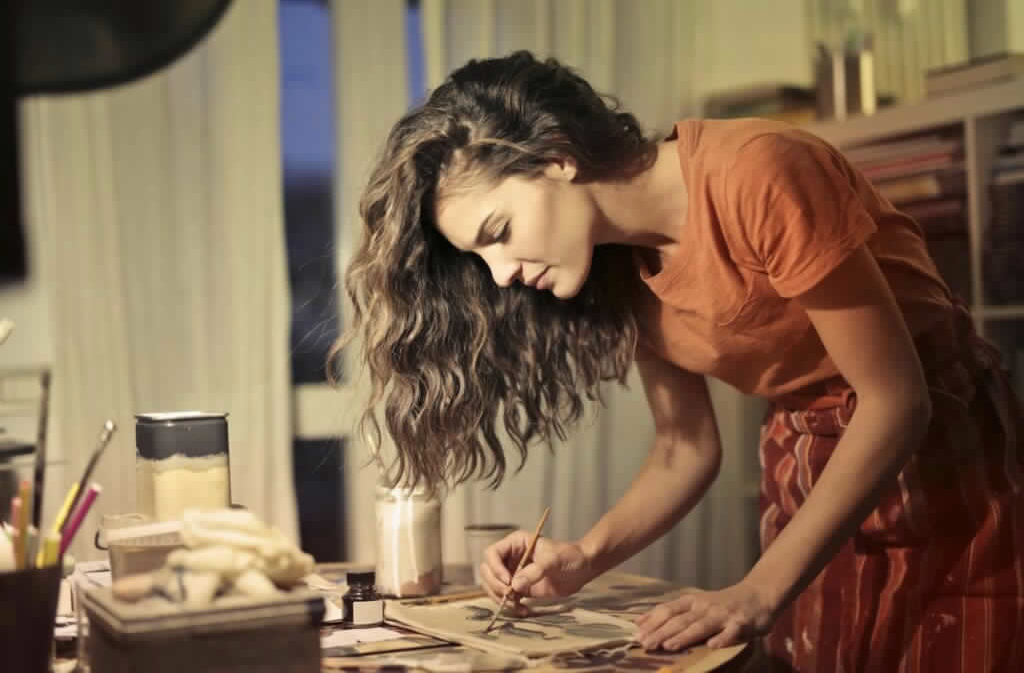

In [660]:
jpeg_compressed_org_size

In [661]:
img_array.shape

(673, 1024, 3)

In [662]:
print(cropped_img.shape, cropped_img.dtype)
raw_bytes = cropped_img.nbytes
raw_kb = raw_bytes / 1024
print("Original (raw) size:", raw_bytes, "bytes  (~", raw_kb, "KB)")


(1024, 1024, 3) uint8
Original (raw) size: 3145728 bytes  (~ 3072.0 KB)


In [663]:
total_bits = len(y_bits) + len(cb_bits) + len(cr_bits)
compressed_bytes = (total_bits + 7) // 8   # round up to full bytes
compressed_kb = compressed_bytes / 1024

print("Compressed size (bitstream only):", compressed_bytes, "bytes  (~", compressed_kb, "KB)")


Compressed size (bitstream only): 89876 bytes  (~ 87.76953125 KB)


In [664]:
(raw_kb - compressed_kb) / raw_kb * 100

97.1429189046224

In [665]:
compressed_kb / raw_kb * 100

2.8570810953776045

In [666]:
img_array.shape

(673, 1024, 3)